In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import folium # plotting library
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# libraries for displaying images
from IPython.display import Image
from IPython.core.display import HTML
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

In [2]:
# read data file
df = pd.read_csv('mrt_lrt_data2.csv')
df.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [3]:
# Basic type information about data
df.dtypes

station_name     object
type             object
lat             float64
lng             float64
dtype: object

In [4]:
#check number of LRT and MRT stations
df_group = df.groupby('type').count()
df_group

,station_name,lat,lng
type,,,
LRT,38,38,38
MRT,119,119,119


In [5]:
#Get MRT data into new dataframe - confine analysis to MRT stations
df_MRT = df.loc[df['type'] == 'MRT']
df_MRT.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [6]:
# check size of MRT data
df_MRT.shape

(119, 4)

In [7]:
# create map of MRT stations using latitude and longitude values
latitude = 1.333207
longitude = 103.742308
map_stations = folium.Map(location=[latitude, longitude], zoom_start=11)
# add markers to map
for lat, lng, label in zip(df_MRT['lat'], df_MRT['lng'], df_MRT['station_name']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_stations)
map_stations

In [8]:
#Define Foursquare Credentials and Version
CLIENT_ID = 'FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P' # your Foursquare ID
CLIENT_SECRET = 'SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P
CLIENT_SECRET:SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB


In [9]:
#first station locaton 
df_MRT.loc[0, 'station_name']

'Jurong East'

In [10]:
#get latitude and longitude of Jurong East
station_latitude = df_MRT.loc[0, 'lat'] # station latitude value
station_longitude = df_MRT.loc[0, 'lng'] # station longitude value
station_name = df_MRT.loc[0, 'station_name'] # station name
print('Latitude and longitude values of {} are {}, {}.'.format(station_name, station_latitude, station_longitude))

Latitude and longitude values of Jurong East are 1.333207, 103.742308.


In [11]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    station_latitude,
    station_longitude,
    radius,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=FDY3QVWSW23NMBO4PHY5FOJQ5UVROZ5F0ZX1E1TIUFY0AF2P&client_secret=SWWAWUV1E1JRRGXIBXWOBVRDZINMQD5FCYJBULLTZ0GLPLGB&v=20180605&ll=1.333207,103.742308&radius=500&limit=100'

In [12]:
results = requests.get(url).json() #get results
results

{'meta': {'code': 200, 'requestId': '5e74dc66660a9f001ea09003'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Jurong East',
  'headerFullLocation': 'Jurong East, Singapore',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 76,
  'suggestedBounds': {'ne': {'lat': 1.3377070045000046,
    'lng': 103.74680081871648},
   'sw': {'lat': 1.3287069954999955, 'lng': 103.73781518128351}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '51c0356c498e19c820f5e48e',
       'name': 'UNIQLO',
       'location': {'address': '#02-37 & #03-30, Jem',
        'crossStreet': '50 Jurong Gateway Rd',
        'lat': 1.333175096970959,
        'lng': 103.74316037528905,
        'labeledLat

In [13]:
#define get_category_type function
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [14]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)

In [15]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,UNIQLO,Clothing Store,1.333175,103.743160
1,MUJI 無印良品,Furniture / Home Store,1.333187,103.743064
2,Song Fa Bak Kut Teh 松發肉骨茶,Chinese Restaurant,1.333394,103.743420
3,Johan Paris,Bakery,1.334083,103.742384
4,The Rink,Skating Rink,1.333424,103.740345


In [16]:
#Map for regions
venues_map = folium.Map(location=[station_latitude, station_longitude], zoom_start=20)
# add a red circle marker to represent the Jurong East station
folium.features.CircleMarker(
    [station_latitude, station_longitude],
    radius=10,
    color='red',
    popup='Jurong East',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)
# add all venues as blue circle markers
for lat, lng, label in zip(nearby_venues.lat, nearby_venues.lng, nearby_venues.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0])) # number of venues returned

76 venues were returned by Foursquare.


In [18]:
#create function to repeat same process
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station_Latitude', 
                  'Station_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    return(nearby_venues)

In [19]:
station_venues = getNearbyVenues(names=df_MRT['station_name'],
                                 latitudes=df_MRT['lat'], 
                                 longitudes=df_MRT['lng'])

Jurong East
Bukit Batok
Bukit Gombak
Choa Chu Kang
Yew Tee
Kranji
Marsiling
Woodlands
Admiralty
Sembawang
Yishun
Khatib
Yio Chu Kang
Ang Mo Kio
Bishan
Braddell
Toa Payoh
Novena
Newton
Orchard
Somerset
Dhoby Ghaut
City Hall
Raffles Place
Marina Bay
Marina South Pier
Tuas Link
Tuas West Road
Tuas Crescent
Gul Circle
Joo Koon
Pioneer
Boon Lay
Lakeside
Chinese Garden
Clementi
Dover
Buona Vista
Commonwealth
Queenstown
Redhill
Tiong Bahru
Outram Park
Tanjong Pagar
Bugis
Lavender
Kallang
Aljunied
Paya Lebar
Eunos
Kembangan
Bedok
Tanah Merah
Simei
Tampines
Pasir Ris
Expo
Changi Airport
HarbourFront
Chinatown
Clarke Quay
Little India
Farrer Park
Boon Keng
Potong Pasir
Woodleigh
Serangoon
Kovan
Hougang
Buangkok
Sengkang
Punggol
Bras Basah
Esplanade
Promenade
Nicoll Highway
Stadium
Mountbatten
Dakota
MacPherson
Tai Seng
Bartley
Lorong Chuan
Marymount
Caldecott
Botanic Gardens
Farrer Road
Holland Village
one-north
Kent Ridge
Haw Par Villa
Pasir Panjang
Labrador Park
Telok Blangah
Bayfront
Bukit Pa

In [20]:
#check size of station_venues
print(station_venues.shape)
station_venues.sample(10)

(4723, 7)


,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
1051,Marina Bay,1.276481,103.854598,Marina Bay Financial Centre (MBFC) Tower 3,1.279109,103.854420,Building
2114,Tampines,1.354467,103.943325,J's Wok & Grill,1.352120,103.941506,Mediterranean Restaurant
440,Braddell,1.340550,103.847098,Chey Sua Carrot Cake,1.338012,103.844661,Chinese Breakfast Place
395,Bishan,1.350920,103.848206,Gourmet Food Court,1.350661,103.850668,Food Court
2670,Farrer Park,1.312679,103.854872,Machan's Kitchen,1.310036,103.851390,Restaurant
4053,Rochor,1.303601,103.852581,DECK,1.301771,103.851645,Art Gallery
3298,Stadium,1.302847,103.875417,Popeyes Louisiana Kitchen,1.303195,103.873082,Fried Chicken Joint
4399,Bencoolen,1.298477,103.849984,Toast Box,1.298130,103.849891,Café
1214,Lakeside,1.344264,103.720797,7-Eleven,1.346075,103.718105,Grocery Store
1271,Clementi,1.314925,103.765341,Prata Alley,1.312084,103.765132,Asian Restaurant


In [21]:
#find unique categories number
print('There are {} unique venue categories.'.format(len(station_venues['Venue_Category'].unique())))

There are 322 unique venue categories.


In [22]:
#find unique venue number
print('There are {} uniques venues.'.format(len(station_venues['Venue'].unique())))#number of unique venues

There are 3223 uniques venues.


In [23]:
station_venues.groupby('Station').count()

,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
Station,,,,,,
Admiralty,9,9,9,9,9,9
Aljunied,50,50,50,50,50,50
Ang Mo Kio,40,40,40,40,40,40
Bartley,10,10,10,10,10,10
Bayfront,50,50,50,50,50,50
Beauty World,78,78,78,78,78,78
Bedok,57,57,57,57,57,57
Bedok North,17,17,17,17,17,17
Bedok Reservoir,8,8,8,8,8,8


In [24]:
# one hot encoding
station_onehot = pd.get_dummies(station_venues[['Venue_Category']], prefix="", prefix_sep="")
# add station column back to dataframe
station_onehot['Station'] = station_venues['Station']
# move station column to the first column
fixed_columns = [station_onehot.columns[-1]] + list(station_onehot.columns[:-1])
station_onehot = station_onehot[fixed_columns]
station_onehot.head()

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Jurong East,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#size of new one-hot dataframe
station_onehot.shape

(4723, 323)

In [26]:
#group rows by station and by taking the mean of the frequency of occurrence of each category
station_grouped = station_onehot.groupby('Station').mean().reset_index()
station_grouped

,Station,ATM,Accessories Store,Airport,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yunnan Restaurant
0,Admiralty,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
1,Aljunied,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
2,Ang Mo Kio,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
3,Bartley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
4,Bayfront,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000,0.00,0.000000,...,0.000000,0.000000,0.040000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
5,Beauty World,0.012821,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
6,Bedok,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.017544,0.00,0.000000,0.000000
7,Bedok North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
8,Bedok Reservoir,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000
9,Bencoolen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.02,0.010000,...,0.000000,0.000000,0.000000,0.020000,0.000000,0.0,0.000000,0.00,0.020000,0.000000


In [27]:
#get size
station_grouped.shape

(119, 323)

In [28]:
#print each station along with the top 5 most common venues
num_top_venues = 5
for stn in station_grouped['Station']:
    print("----"+stn+"----")
    temp = station_grouped[station_grouped['Station'] == stn].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Admiralty----
         venue  freq
0  Supermarket  0.22
1   Food Court  0.11
2  Bus Station  0.11
3          Spa  0.11
4         Park  0.11


----Aljunied----
                venue  freq
0  Chinese Restaurant  0.12
1        Noodle House  0.10
2         Coffee Shop  0.08
3    Asian Restaurant  0.08
4          Food Court  0.06


----Ang Mo Kio----
             venue  freq
0      Coffee Shop  0.12
1     Dessert Shop  0.08
2       Food Court  0.08
3      Supermarket  0.05
4  Bubble Tea Shop  0.05


----Bartley----
                venue  freq
0         Bus Station   0.4
1        Noodle House   0.2
2  Seafood Restaurant   0.1
3           Pet Store   0.1
4                Café   0.1


----Bayfront----
                venue  freq
0               Hotel  0.08
1            Boutique  0.06
2              Bridge  0.04
3            Tea Room  0.04
4  Italian Restaurant  0.04


----Beauty World----
                venue  freq
0                Café  0.10
1  Chinese Restaurant  0.10
2   Korean Restaur

         venue  freq
0  Coffee Shop  0.29
1         Café  0.14
2   Food Court  0.14
3  Supermarket  0.14
4         Pool  0.14


----Gul Circle----
               venue  freq
0               Park  0.25
1      Train Station  0.25
2        Coffee Shop  0.25
3  Electronics Store  0.25
4                ATM  0.00


----HarbourFront----
                  venue  freq
0    Chinese Restaurant  0.07
1   Japanese Restaurant  0.06
2           Coffee Shop  0.04
3        Clothing Store  0.04
4  Fast Food Restaurant  0.04


----Haw Par Villa----
                venue  freq
0    Asian Restaurant  0.22
1       Metro Station  0.11
2  Miscellaneous Shop  0.11
3    Sculpture Garden  0.11
4         Coffee Shop  0.11


----Hillview----
           venue  freq
0           Café  0.11
1    Supermarket  0.07
2           Pool  0.07
3  Shopping Mall  0.07
4    Coffee Shop  0.07


----Holland Village----
            venue  freq
0          Bakery  0.09
1  Ice Cream Shop  0.07
2             Bar  0.07
3     Pizza Place

                 venue  freq
0          Coffee Shop  0.11
1   Chinese Restaurant  0.11
2  Japanese Restaurant  0.11
3         Noodle House  0.05
4  Fried Chicken Joint  0.05


----Sixth Avenue----
               venue  freq
0             Bakery  0.12
1        Bus Station  0.06
2         Food Court  0.06
3           Building  0.06
4  Indian Restaurant  0.06


----Somerset----
                 venue  freq
0        Shopping Mall  0.07
1                Hotel  0.07
2  Japanese Restaurant  0.06
3       Clothing Store  0.05
4   Chinese Restaurant  0.03


----Stadium----
            venue  freq
0            Café  0.07
1         Stadium  0.07
2  Clothing Store  0.04
3     Supermarket  0.04
4      Soup Place  0.04


----Stevens----
                 venue  freq
0                Diner   0.2
1                 Café   0.2
2       History Museum   0.1
3       Sandwich Place   0.1
4  Japanese Restaurant   0.1


----Tai Seng----
                venue  freq
0  Chinese Restaurant  0.12
1          Food Cou

In [29]:
#Sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# create a new dataframe
station_venues_sorted = pd.DataFrame(columns=columns)
station_venues_sorted['Station'] = station_grouped['Station']
for ind in np.arange(station_grouped.shape[0]):
    station_venues_sorted.iloc[ind, 1:] = return_most_common_venues(station_grouped.iloc[ind, :], num_top_venues)
station_venues_sorted.head()

,Station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Admiralty,Supermarket,Park,Spa,Convenience Store,Plaza,Bus Station,Food Court,Coffee Shop,Food & Drink Shop,Field
1,Aljunied,Chinese Restaurant,Noodle House,Asian Restaurant,Coffee Shop,Vegetarian / Vegan Restaurant,Food Court,Dim Sum Restaurant,Breakfast Spot,Bus Station,Seafood Restaurant
2,Ang Mo Kio,Coffee Shop,Dessert Shop,Food Court,Supermarket,Bubble Tea Shop,Japanese Restaurant,Multiplex,Ramen Restaurant,Miscellaneous Shop,Fast Food Restaurant
3,Bartley,Bus Station,Noodle House,Seafood Restaurant,Metro Station,Café,Pet Store,Yunnan Restaurant,Food Court,Fish & Chips Shop,Flea Market
4,Bayfront,Hotel,Boutique,Japanese Restaurant,Waterfront,Bar,Theater,Italian Restaurant,Bridge,Tea Room,Lounge


In [31]:
# set number of clusters
kclusters = 5
station_grouped_clustering = station_grouped.drop('Station', 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(station_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 2, 4, 0, 3, 0, 2, 2, 0])

In [32]:
# add clustering labels
station_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
station_merged = df_MRT
# merge station_grouped with station_data to add latitude/longitude for each station
station_merged = station_merged.join(station_venues_sorted.set_index('Station'), on='station_name')
station_merged.head() # check dataframe

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Jurong East,MRT,1.333207,103.742308,0,Japanese Restaurant,Chinese Restaurant,Coffee Shop,Food Court,Shopping Mall,Café,Department Store,Sushi Restaurant,Bubble Tea Shop,Sandwich Place
1,Bukit Batok,MRT,1.349069,103.749596,2,Coffee Shop,Fast Food Restaurant,Food Court,Chinese Restaurant,Park,Frozen Yogurt Shop,Department Store,Multiplex,Café,Bowling Alley
2,Bukit Gombak,MRT,1.359043,103.751863,2,Food Court,Coffee Shop,Stadium,Malay Restaurant,Vegetarian / Vegan Restaurant,Sandwich Place,Flea Market,Halal Restaurant,Supermarket,Steakhouse
3,Choa Chu Kang,MRT,1.385417,103.744316,2,Fast Food Restaurant,Coffee Shop,Lounge,Vietnamese Restaurant,Thai Restaurant,Sushi Restaurant,Park,Supermarket,Bakery,Shop & Service
4,Yew Tee,MRT,1.397383,103.747523,0,Fast Food Restaurant,Japanese Restaurant,Diner,Shopping Mall,Sandwich Place,Café,Food Court,Pool,Fried Chicken Joint,French Restaurant


In [33]:
station_merged.isnull() #check for NaN values

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [34]:
station_merged.dropna(axis = 0, inplace = True)
station_merged.isnull()

,station_name,type,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [35]:
#cast cluster labels as integer for map
station_merged['Cluster Labels'] = station_merged['Cluster Labels'].astype(int)

In [36]:
#visualise results
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(station_merged['lat'], station_merged['lng'], station_merged['station_name'], station_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster - 1],
    fill=True,
    fill_color=rainbow[cluster - 1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters


In [37]:
#group by station and find number of venue category of each type
stn_grp = station_venues.groupby(['Station', 'Venue_Category']).size()
stn_grp

Station    Venue_Category               
Admiralty  Bus Station                      1
           Coffee Shop                      1
           Convenience Store                1
           Food Court                       1
           Park                             1
           Plaza                            1
           Spa                              1
           Supermarket                      2
Aljunied   Asian Restaurant                 4
           BBQ Joint                        2
           Badminton Court                  1
           Boarding House                   1
           Breakfast Spot                   2
           Bus Station                      2
           Café                             1
           Chinese Restaurant               6
           Coffee Shop                      4
           Convenience Store                1
           Dim Sum Restaurant               2
           Farmers Market                   1
           Food Court                  

In [38]:
#find station with max number of venue category
stn_grp.idxmax()

('Jalan Besar', 'Indian Restaurant')

In [39]:
# which indian restaurants
station_venues.query('Station == ["Jalan Besar"] and Venue_Category == ["Indian Restaurant"]')

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
4493,Jalan Besar,1.305551,103.855443,Bismillah Biryani,1.304956,103.853602,Indian Restaurant
4499,Jalan Besar,1.305551,103.855443,Murugan Idli Shop,1.308842,103.856380,Indian Restaurant
4506,Jalan Besar,1.305551,103.855443,Azmi Restaurant,1.308256,103.853075,Indian Restaurant
4507,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.306000,103.852169,Indian Restaurant
4513,Jalan Besar,1.305551,103.855443,Komala Vilas (Buffalo Rd),1.306308,103.851158,Indian Restaurant
4516,Jalan Besar,1.305551,103.855443,Khansama Tandoori Restaurant,1.308251,103.853122,Indian Restaurant
4526,Jalan Besar,1.305551,103.855443,Kailash Parbat,1.308039,103.852660,Indian Restaurant
4527,Jalan Besar,1.305551,103.855443,Lagnaa Barefoot Dining,1.306472,103.852298,Indian Restaurant
4535,Jalan Besar,1.305551,103.855443,Veeras Curry Restaurant @ Hindoo Rd,1.308650,103.853515,Indian Restaurant
4539,Jalan Besar,1.305551,103.855443,Sakunthala's Restaurant,1.309475,103.855717,Indian Restaurant


In [40]:
A = stn_grp.to_frame() # convert series object to dataframe for further analysis
A['Counts'] = A.iloc[:,-1] #rename counts as Counts column
A.head()
A=A.drop([A.columns[-2]], axis = 'columns') # remove duplicate count column
A.head()

Counts
Station   Venue_Category           
Admiralty Bus Station             1
          Coffee Shop             1
          Convenience Store       1
          Food Court              1
          Park                    1

In [41]:
Alist = A.groupby('Venue_Category')['Counts'].sum() #Sum up number for each venue category
Alist

Venue_Category
ATM                                2
Accessories Store                  4
Airport                            2
Airport Lounge                     5
American Restaurant               23
Arcade                             4
Art Gallery                       22
Art Museum                         2
Arts & Crafts Store               11
Asian Restaurant                 126
Athletics & Sports                 3
Australian Restaurant              5
BBQ Joint                         44
Baby Store                         1
Badminton Court                    1
Bagel Shop                         2
Bakery                           124
Bank                               2
Bar                               43
Basketball Court                   6
Bay                                1
Bed & Breakfast                    5
Beer Bar                          16
Beer Garden                        8
Beer Store                         1
Betting Shop                       3
Bike Rental / Bike Shar

In [42]:
Alist.sort_values(ascending = False, inplace = True) #sort venue category in descending order
Top_10 = Alist.head(10) #find top 10 venue category
Top_10

Venue_Category
Coffee Shop             251
Chinese Restaurant      239
Café                    229
Food Court              177
Japanese Restaurant     172
Hotel                   132
Asian Restaurant        126
Bakery                  124
Indian Restaurant       115
Fast Food Restaurant     96
Name: Counts, dtype: int64

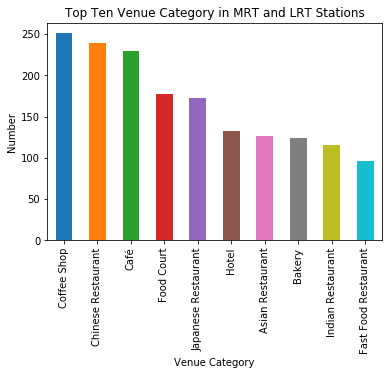

In [45]:
# plot Bar graph
import matplotlib as mpl
import matplotlib.pyplot as plt

Top_10.plot(kind = 'bar')

plt.title('Top Ten Venue Category in MRT and LRT Stations')
plt.xlabel('Venue Category')
plt.ylabel('Number')
plt.show()

In [46]:
#group by station and find number of venue of each type
stn_grp2 = station_venues.groupby(['Station', 'Venue']).size()
stn_grp2

Station    Venue                                          
Admiralty  7-ELEVEN                                           1
           Bus Stop 46769 Blk 666 Woodlands                   1
           Circle Green Park                                  1
           Community Plaza | Kampung Admiralty                1
           Kampung Admiralty Hawker Centre                    1
           NTUC FairPrice                                     1
           NTUC Fairprice                                     1
           New York Skin Solutions                            1
           Starbucks                                          1
Aljunied   7-Eleven                                           1
           Aikido Shinju-kai (Singapore) HQ 心柔会本部道场           1
           Aljunied MRT Station (EW9)                         1
           Best Hub Food Link                                 1
           Builders At Sims                                   1
           Bus Stop 80231 (Blk 59)           

In [47]:
stn_grp2.idxmax() #Find venue with max number and the corresponding station

('Downtown', 'Starbucks')

In [48]:
#detailed analysis on Downtown Starbucks -get new df containing all Starbucks outlets at Downtown Station
Downtown_df = station_venues.loc[(station_venues['Station']=='Downtown') & (station_venues['Venue']=='Starbucks'),['Station', 'Station_Latitude', 'Station_Longitude','Venue','Venue_Latitude', 'Venue_Longitude' ]] 
Downtown_df

,Station,Station_Latitude,Station_Longitude,Venue,Venue_Latitude,Venue_Longitude
4115,Downtown,1.27949,103.852802,Starbucks,1.279335,103.854128
4147,Downtown,1.27949,103.852802,Starbucks,1.277949,103.850985
4166,Downtown,1.27949,103.852802,Starbucks,1.276988,103.852458
4180,Downtown,1.27949,103.852802,Starbucks,1.279422,103.854494


In [49]:
#Plot locations of these Starbucks
#display map with locations of subway
#get downtown latitude, longitude

d_latitude = 1.27949 # station latitude value
d_longitude = 103.852802 # station longitude value

#display map centered on downtown station
downtown_map = folium.Map(location=[d_latitude, d_longitude], zoom_start=17)

#add circle marker on Admiralty station
folium.features.CircleMarker(
    [d_latitude, d_longitude],
    radius=10,
    popup='Downtown',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(downtown_map)

for lat, lng, label in zip(Downtown_df.Venue_Latitude, Downtown_df.Venue_Longitude, Downtown_df.Venue):
    folium.features.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    fill=True,
    color='blue',
    fill_color='blue',
    fill_opacity=0.6
    ).add_to(downtown_map)
    
# display map
downtown_map

In [50]:
#find atm locations
ATM_df = station_venues.loc[(station_venues['Venue_Category']=='ATM'),['Station', 'Station_Latitude', 'Station_Longitude','Venue_Category', 'Venue','Venue_Latitude', 'Venue_Longitude' ]]
ATM_df

,Station,Station_Latitude,Station_Longitude,Venue_Category,Venue,Venue_Latitude,Venue_Longitude
1132,Pioneer,1.337645,103.697420,ATM,POSB ATM,1.340155,103.697610
3959,Beauty World,1.341607,103.775682,ATM,POSB ATM @ Toh Yi,1.339966,103.773484


In [51]:
#End